In [1]:
import numpy as np
import torch
import os
from tqdm.notebook import tqdm

from deepnote import MusicRepr, Constants
from importlib import reload

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

seed_everything(42)

/home/soroosh/projects/general_env/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(
Global seed set to 42


42

## Data

In [2]:
const = Constants(unit=4, num_tempo_bins=20, num_velocity_bins=20)

data_config = {
    'data_dir' : '/home/soroosh/data/MIDI/pop909/train/',
#     'data_dir' : '/home/soroosh/data/MIDI/e-gmd-v1.0.0/midis_processed/',
#     'data_dir' : '/home/soroosh/data/MIDI/lmd_processed/',
    'const' : const,
    'instruments' : ['piano', 'drums'],
    'mode' : 'cp',
    'max_files' : 10,
    'window_len' : 1024,
    'pad_value' : 0,
    'n_jobs' : 20
}

name = 'cp-small-v-simplehead-ae-pop-win1024'
print('model name:',name)

model name: cp-small-v-simplehead-ae-pop-win1024


In [33]:
import src.data
reload(src.data)
from src.data import MidiDataset

dataset = MidiDataset(**data_config)
n = len(dataset)
n

  0%|          | 0/10 [00:00<?, ?it/s]

14482

In [34]:
from torch.utils.data import DataLoader, random_split

t = int(0.1 * n)
td, vd = random_split(dataset, [n-t, t])
tl = DataLoader(dataset=td, batch_size=16, pin_memory=False, shuffle=True, num_workers=4, collate_fn=dataset.fn)
vl = DataLoader(dataset=vd, batch_size=32, pin_memory=False, shuffle=False, num_workers=4, collate_fn=dataset.fn)

In [35]:
b = next(iter(tl))
for k in b:
    print(k, b[k].shape, b[k].device)

X torch.Size([16, 1023, 8]) cpu
X_len torch.Size([16]) cpu
labels torch.Size([16, 1023, 8]) cpu


## Model

In [3]:
import src.config
reload(src.config)
from src.config import make_config
from transformers import GPT2Config, TransfoXLConfig


config = make_config(
    const,
    mode='cp',
    model='transformer',
    d_model=256, 
    max_len=10000,
    dropout=0.1, 
    lr=2e-4,
    tie_emb=False,
    pos_emb='relative', 
    n_layer=4, 
    n_head=8, 
    d_inner=256, 
    activation='gelu'
)

# config = make_config(
#     const,
#     mode='remi',
#     model='transformer',
#     d_model=256, 
#     max_len=10000,
#     dropout=0.1, 
#     lr=2e-4,
#     tie_emb=False,
#     pos_emb='relative', 
#     n_layer=4, 
#     n_head=8, 
#     d_inner=256, 
#     activation='gelu'
# )

# config = {
#     'lr' : 1e-4,
#     'transformer': TransfoXLConfig(
#         vocab_size=len(const.all_tokens) + 1,
#         cutoffs=[],
#         d_model=256,
#         d_embed=256,
#         d_head=32,
#         n_head=8,
#         d_inner=256,
#         n_layer=4,
#         dropout=0.1,
#         clamp_len=512,
#         pad_token_id=len(const.all_tokens),
#         eos_token_id=1,
#         bos_token_id=0
#     )
# }
config

{'lr': 0.0002,
 'embedding': {'d_model': 256,
  'dropout': 0.1,
  'max_len': 10000,
  'positional_embedding': 'relative',
  'attributes': ['ttype',
   'barbeat',
   'tempo',
   'chord',
   'inst_family',
   'pitch',
   'duration',
   'velocity'],
  'n_tokens': {'ttype': 2,
   'barbeat': 16,
   'tempo': 21,
   'chord': 133,
   'inst_family': 17,
   'pitch': 128,
   'duration': 16,
   'velocity': 20},
  'emb_sizes': {'ttype': 8,
   'barbeat': 32,
   'tempo': 32,
   'chord': 128,
   'inst_family': 32,
   'pitch': 128,
   'duration': 32,
   'velocity': 32}},
 'head': {'d_model': 256,
  'attributes': ['ttype',
   'barbeat',
   'tempo',
   'chord',
   'inst_family',
   'pitch',
   'duration',
   'velocity'],
  'n_tokens': {'ttype': 2,
   'barbeat': 16,
   'tempo': 21,
   'chord': 133,
   'inst_family': 17,
   'pitch': 128,
   'duration': 16,
   'velocity': 20},
  'emb_sizes': {'ttype': 8,
   'barbeat': 32,
   'tempo': 32,
   'chord': 128,
   'inst_family': 32,
   'pitch': 128,
   'duration':

In [36]:
# from src.models.remi import RemiLinearTransformer, RemiHFTransformer, RemiTransformer
from src.models.cp import CPSimpleTransformer

# model = CPSimpleTransformer(config)
model = CPSimpleTransformer.load_from_checkpoint(f'weights/{name}/last.ckpt', config=config)
model.count_parameters()

1818929

In [37]:
logger = TensorBoardLogger(save_dir='logs/', name=name)
lr_logger = LearningRateMonitor(logging_interval='step')
checkpoint = ModelCheckpoint(
    dirpath=f'weights/{name}/', 
    filename='{epoch}-{val_loss:.2f}', 
    monitor='train_loss',
    save_top_k=5, 
    period=1
)

trainer = Trainer(
    benchmark=True, 
    gpus=1, 
    accumulate_grad_batches=1,
    logger=logger, 
    max_epochs=10,
    callbacks=[checkpoint, lr_logger]
)

/home/soroosh/projects/general_env/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:396: LightningDeprecationWarning: Argument `period` in `ModelCheckpoint` is deprecated in v1.3 and will be removed in v1.5. Please use `every_n_val_epochs` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [38]:
trainer.fit(model, tl, vl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | loss_func   | CrossEntropyLoss   | 0     
1 | embedding   | CPEmbedding        | 145 K 
2 | transformer | VanillaTransformer | 1.6 M 
3 | head        | CPSimpleHead       | 90.7 K
---------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.276     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [39]:
trainer.save_checkpoint(f'weights/{name}/last.ckpt')

## generate

In [40]:
# from src.models.remi import RemiHFTransformer, RemiTransformer
from src.models.cp import CPLinearTransformer, CPTransformer, CPSimpleTransformer


gen_model = CPSimpleTransformer.load_from_checkpoint(f"weights/{name}/last.ckpt", config=config)

In [49]:
path = data_config['data_dir']
import random
idx = random.randint(0, 1600)
print('idx: ', idx)
seq = MusicRepr.from_file(path + os.listdir(path)[idx], const=const)
tracks = seq.separate_tracks()
tracks = dict([(k,v) for k,v in tracks.items() if k in ['piano']])
seq = MusicRepr.merge_tracks(tracks)
print(seq.get_instruments())
prompt = MusicRepr.concatenate(seq.get_bars()[:5])
len(prompt), len(prompt.to_cp())

idx:  51
['piano']


(78, 78)

In [64]:
gen_conf = {
    'p_ttype' : 1.,
    't_ttype' : .2,
    'p_barbeat' : 1.,
    't_barbeat' : .5,
    'p_tempo' : 1.,
    't_tempo' : .5,
    'p_chord' : 1.,
    't_chord' : .5,
    'p_inst_family' : 1.,
    't_inst_family' : 0.5,
    'p_pitch' : 1.,
    't_pitch' : .5,
    'p_duration' : 1.,
    't_duration' : .5,
    'p_velocity' : 1.,
    't_velocity' : .5,
}


gen_cp = gen_model.generate(prompt=prompt, max_len=100, window=500, cuda=True, gen_conf=gen_conf)
gen_cp.shape

  0%|          | 0/100 [00:00<?, ?it/s]

(178, 8)

In [65]:
gen_seq = MusicRepr.from_cp(gen_cp.astype(int), const=const)
len(gen_seq), gen_seq.get_bar_count()

(150, 74)

In [66]:
gen_seq[:30]

[Bar(position=0, tempo=115),
 Beat(position=11),
 Note(inst_family=piano, pitch=66, duration=2, velocity=67),
 Note(inst_family=piano, pitch=71, duration=2, velocity=73),
 Note(inst_family=piano, pitch=68, duration=3, velocity=67),
 Beat(position=14),
 Note(inst_family=piano, pitch=75, duration=1, velocity=73),
 Note(inst_family=piano, pitch=66, duration=5, velocity=60),
 Note(inst_family=piano, pitch=71, duration=5, velocity=54),
 Note(inst_family=piano, pitch=63, duration=5, velocity=54),
 Note(inst_family=piano, pitch=59, duration=9, velocity=54),
 Bar(position=0, tempo=101),
 Beat(position=3),
 Note(inst_family=piano, pitch=66, duration=4, velocity=54),
 Note(inst_family=piano, pitch=71, duration=4, velocity=60),
 Beat(position=4),
 Note(inst_family=piano, pitch=63, duration=3, velocity=47),
 Beat(position=7),
 Note(inst_family=piano, pitch=63, duration=3, velocity=54),
 Note(inst_family=piano, pitch=66, duration=3, velocity=54),
 Note(inst_family=piano, pitch=71, duration=3, veloc

In [67]:
# gen_remi = gen_model.generate(prompt=None, max_len=1000, window=500, cuda=True, top_p=.9, temperature=.7)
# print(gen_remi.shape)

# tokens = [const.all_tokens[idx] for idx in gen_remi]
# print(tokens[:10])
# gen_seq = MusicRepr.from_string(' '.join(tokens), const=const)
# len(gen_seq), gen_seq.get_bar_count()

In [68]:
gen_seq.to_midi('cp-v-piano.mid')

ticks per beat: 480
max tick: 136320
tempo changes: 13
time sig: 1
key sig: 0
markers: 9
lyrics: False
instruments: 1

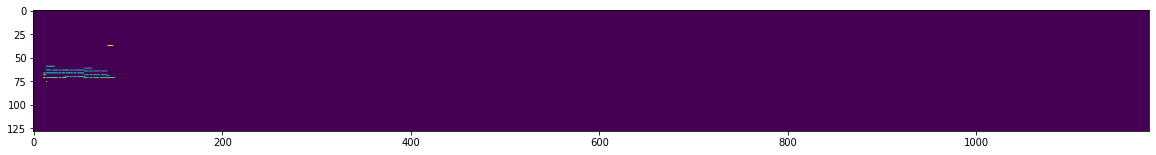

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.imshow(gen_seq.to_pianoroll(add_tempo_chord=False)['piano'])